### Description

In this notebook Sentiment Analysis will be performed - a process of assigning whether document is positive or negative.

It will be done on very popular dataset of [imdb.com](imdb.com) movie reviews which can be obtained for free at http://ai.stanford.edu/~amaas/data/sentiment/ website.

Solution will be divided into two cases:
1. Simple Machine Learning models with usage of Bag of Words technique.
2. Simple Machine Learning models with usage of TF-IDF technique.
3. Bidirectional Recurrent Neural Network.

### Imports

In [1]:
import re
import os
import sys
import time
import random
import shutil
import tarfile
import itertools
import urllib.request
from pathos.multiprocessing import ProcessingPool as Pool
from contextlib import contextmanager
from collections import Counter

from tqdm import tqdm

import nltk
for package in ["pun|kt", "wordnet", "stopwords"]:
    nltk.download(package)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from hyperopt import hp
from hyperopt import STATUS_OK, fmin, tpe, space_eval

import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import get_custom_objects

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

[nltk_data] Error loading pun|kt: Package 'pun|kt' not found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kamilkrzyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kamilkrzyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Constants

In [2]:
DATA_LINK = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
TEMP_FOLDER = "temp"
GLOBAL_SEED = 2020

### Data

- Code

In [3]:
def download_data():
    """"""
    
    # Creating empty folder
    if not os.path.exists(TEMP_FOLDER):
        os.mkdir(TEMP_FOLDER)
        
    # Downloading data to temp directory
    filepath = os.path.join(TEMP_FOLDER, DATA_LINK.split("/")[-1])
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(DATA_LINK, filepath)
    
    # Unpacking data
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=TEMP_FOLDER)
        
    # Loading raw data
    train_data_positive_path = os.path.join(TEMP_FOLDER, "aclImdb", "train", "pos")
    train_data_negative_path = os.path.join(TEMP_FOLDER, "aclImdb", "train", "neg")
    test_data_positive_path = os.path.join(TEMP_FOLDER, "aclImdb", "test", "pos")
    test_data_negative_path = os.path.join(TEMP_FOLDER, "aclImdb", "test", "neg")
    
    train_data = {"review": [], "sentiment": []}
    test_data = {"review": [], "sentiment": []}
    
    def _dir_to_data(directory, sentiment, data_dict):
        """Loads .txt files in directory and saves text in data_dict along with sentiment 
        information
        """
        files = os.listdir(directory)
        for i in tqdm(range(len(files)), desc="Loading foles from '{}' dir...".format(directory)):
            with open(os.path.join(directory, files[i]), "r") as f:
                data_dict["review"].append(f.read())
                data_dict["sentiment"].append(sentiment)
                
    _dir_to_data(train_data_positive_path, "positive", train_data)
    _dir_to_data(train_data_negative_path, "negative", train_data)
    _dir_to_data(test_data_positive_path, "positive", test_data)
    _dir_to_data(test_data_negative_path, "negative", test_data)
    
    # Cleaning temp files
    shutil.rmtree(TEMP_FOLDER)
    
    return pd.DataFrame(train_data), pd.DataFrame(test_data)

- Loading data

In [4]:
df_train, df_test = download_data()

Loading foles from 'temp/aclImdb/train/pos' dir...: 100%|██████████| 12500/12500 [00:00<00:00, 18753.73it/s]
Loading foles from 'temp/aclImdb/train/neg' dir...: 100%|██████████| 12500/12500 [00:00<00:00, 18962.52it/s]
Loading foles from 'temp/aclImdb/test/pos' dir...: 100%|██████████| 12500/12500 [00:00<00:00, 18758.75it/s]
Loading foles from 'temp/aclImdb/test/neg' dir...: 100%|██████████| 12500/12500 [00:00<00:00, 19434.65it/s]


- Preview

In [5]:
df_train.shape

(25000, 2)

In [6]:
df_train.head()

,review,sentiment
0,For a movie that gets no respect there sure ar...,positive
1,Bizarre horror movie filled with famous faces ...,positive
2,"A solid, if unremarkable film. Matthau, as Ein...",positive
3,It's a strange feeling to sit alone in a theat...,positive
4,"You probably all already know this by now, but...",positive


In [7]:
df_test.shape

(25000, 2)

In [8]:
df_test.head()

,review,sentiment
0,"Based on an actual story, John Boorman shows t...",positive
1,This is a gem. As a Film Four production - the...,positive
2,"I really like this show. It has drama, romance...",positive
3,This is the best 3-D experience Disney has at ...,positive
4,"Of the Korean movies I've seen, only three had...",positive


In [9]:
reviews_to_show = 2

print("--- Train reviews example:")
for review_id in random.sample(range(len(df_train)), reviews_to_show):
    print(df_train["review"].iloc[review_id], end="\n\n")
    
print("--- Test reviews example:")
for review_id in random.sample(range(len(df_test)), reviews_to_show):
    print(df_test["review"].iloc[review_id], end="\n\n")

--- Train reviews example:
Would anyone really watch this RUBBISH if it didn't contain little children running around nude? From a cinematic point of view it is probably one of the worst films I have encountered absolutely dire. Some perv woke up one day and thought I will make a film with little girls in and call it art, stick them in countryside and there isn't any need for a story or explanation of how they got there or why they don't appear to live anywhere or have parents because p*rn films don't need anything like that. I would comment on the rest of the film but I haven't ticked spoilers so I will just say avoid, avoid avoid and find yourself a proper film to watch

A horror movie is being shot and things aren't going well. It's about a masked killer. The director tells off the killer in front of the cast and crew. He goes crazy and kills two people. He's killed himself and the film is never finished. Twelve years later a bunch of film students decide to try and finish it--but t

### Data Cleaning - Creating Tokens

- Code

In [10]:
def tokenize(document, lemmatizer=WordNetLemmatizer(), stemmer=PorterStemmer()):
    """Operation of dividing single document into list of tokens. Tokens are cleaned by:
        1. Removing HTML from text.
        2. Casting words to lowercase.
        3. Removing punctuation.
        4. Removing words containing digits and digits.
        5. Removing stopwords.
        6. Removal of tokens shorter than 3 letters.
        8. Lemmatization.
        9. Stemming.
    """
    
    document_cleaned = BeautifulSoup(document, "html.parser").get_text()
    document_cleaned = document.lower()
    document_cleaned = re.sub(r"[^a-zA-Z0-9]", " ", document_cleaned)
    document_cleaned = re.sub(r"\w*\d\w*", "", document_cleaned)
    
    tokens = []
    
    for token in word_tokenize(document_cleaned):
        if token not in stopwords.words("english") and len(token) > 3:
            token = stemmer.stem(token)
            token = lemmatizer.lemmatize(token)
            tokens.append(token)

    return tokens

def tokenize_corpus(corpus, tokenize_func=tokenize, workers_num=12):
    """Wrapper on 'tokenize' function that accelerates preprocessing via multiprocessing."""   
    
    def _process_chunk(chunks):        
        document_tokens = []
        for i, document in enumerate(chunks):
            document_tokens.append(tokenize_func(document))
            
        return document_tokens
    
    corpus_size = len(corpus)
    chunk_size = int(np.ceil(corpus_size / workers_num))
    
    chunks = []
    for i in range(workers_num):
        chunk_lower_th, chunk_higher_th = i * chunk_size, (i + 1) * chunk_size
        chunk_higher_th = corpus_size if chunk_higher_th >= corpus_size else chunk_higher_th
        chunks.append(corpus[chunk_lower_th:chunk_higher_th])
            
    with Pool(workers_num) as pool:
        sys.stdout.flush()
        results = pool.map(_process_chunk, chunks)
        
    return sum(results, [])

- Preprocessing

In [11]:
print("Preprocessing train reviews...")
train_tokens = tokenize_corpus(df_train["review"])

print("\nPreprocessing test reviews...")
test_tokens = tokenize_corpus(df_test["review"])

print("\nCreating train targets...")
train_targets = (df_train["sentiment"] == "positive").astype(int)

print("\nCreating test targets...")
test_targets = (df_test["sentiment"] == "positive").astype(int)

Preprocessing train reviews...

Preprocessing test reviews...

Creating train targets...

Creating test targets...


- Preview

In [12]:
print(train_tokens[112])
print(train_tokens[522])

['clair', 'deni', 'demonstr', 'repeatedli', 'film', 'need', 'tell', 'stori', 'suffici', 'creat', 'experi', 'allow', 'viewer', 'take', 'ingredi', 'make', 'ostens', 'idea', 'within', 'framework', 'linear', 'film', 'older', 'live', 'french', 'swiss', 'border', 'devot', 'dog', 'still', 'lover', 'whose', 'cardiac', 'statu', 'increasingli', 'threaten', 'life', 'littl', 'famili', 'infrequ', 'meet', 'discov', 'need', 'heart', 'transplant', 'opt', 'go', 'tahiti', 'japan', 'obtain', 'heart', 'transplant', 'black', 'market', 'rekindl', 'long', 'lost', 'relationship', 'form', 'tahitian', 'woman', 'year', 'deni', 'outlin', 'stori', 'camera', 'explor', 'loneli', 'soul', 'vast', 'natur', 'interact', 'peopl', 'anim', 'much', 'time', 'film', 'make', 'sen', 'hard', 'connect', 'dot', 'laid', 'beauti', 'pictur', 'life', 'sort', 'like', 'look', 'observ', 'integr', 'process', 'make', 'use', 'form', 'film', 'make', 'much', 'strang', 'beauti', 'beau', 'travail', 'clair', 'deni', 'develop', 'signatur', 'techni

Looking at tokens connected to "positive" and "negative" reviews. Previewing tokens after ignoring start of both most common token lists as those are the same.

In [13]:
positive_train_tokens = Counter()
negative_train_tokens = Counter()
for document_tokens, is_pos in zip(train_tokens, df_train["sentiment"] == "positive"):
    if is_pos:
        positive_train_tokens.update(document_tokens)
    else:
        negative_train_tokens.update(document_tokens)
        
print("Positive review tokens:")
for i, token_count in enumerate(positive_train_tokens.most_common()[100:120]):
    print("\t{}. {}".format(i, token_count))
    
print("\nNegative review tokens:")
for i, token_count in enumerate(negative_train_tokens.most_common()[100:120]):
    print("\t{}. {}".format(i, token_count))

Positive review tokens:
	0. ('final', 1717)
	1. ('episod', 1698)
	2. ('effect', 1683)
	3. ('around', 1674)
	4. ('without', 1672)
	5. ('last', 1663)
	6. ('use', 1647)
	7. ('tell', 1640)
	8. ('place', 1615)
	9. ('entertain', 1606)
	10. ('need', 1604)
	11. ('help', 1598)
	12. ('happen', 1592)
	13. ('done', 1586)
	14. ('especi', 1576)
	15. ('almost', 1566)
	16. ('child', 1558)
	17. ('begin', 1556)
	18. ('moment', 1554)
	19. ('pretti', 1550)

Negative review tokens:
	0. ('mean', 1738)
	1. ('music', 1737)
	2. ('right', 1717)
	3. ('action', 1709)
	4. ('shot', 1685)
	5. ('comedi', 1678)
	6. ('use', 1674)
	7. ('sure', 1665)
	8. ('might', 1658)
	9. ('aw', 1657)
	10. ('idea', 1654)
	11. ('quit', 1650)
	12. ('money', 1643)
	13. ('role', 1642)
	14. ('laugh', 1639)
	15. ('kind', 1631)
	16. ('call', 1618)
	17. ('without', 1596)
	18. ('terribl', 1590)
	19. ('expect', 1588)


### Vectorization of the reviews - Bag of Words and TF-IDF

Already preprocessed tokens with `tokenize_corpus` are used. `CountVectorizer` doesn't support `njobs` parameter that allows multiprocessing therefore it's slow. Created `tokenize_corpus` function preprocess whole corpus about 6 times faster than single for loop (on my current machine). 

By preprocessing data once, different kind of `CountVectorizers` can be created very fast. If `tokenize` functian was used as `tokenizer` each `CountVectorizer` would need to preprocess whole corpus from scratch.

- Tokenizer code

In [14]:
def return_tokens(token_list):
    """Proxy function so CountVectorizer can use already preprocessed corpus where each document
    is a list of tokens.
    """
    return token_list

- Bag of words - no ngrams

In [15]:
bow = CountVectorizer(
    analyzer="word", 
    min_df=15, 
    max_df=0.75, 
    max_features=15000,
    lowercase=False,
    tokenizer=return_tokens
)

bow.fit(train_tokens)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.75, max_features=15000, min_df=15,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function return_tokens at 0x15687fae8>, vocabulary=None)

In [16]:
print("Dictionary size: {}".format(len(bow.get_feature_names())))

Dictionary size: 9779


- Bag of words - ngrams (1,2)

In [17]:
bow_ngrams_12 = CountVectorizer(
    analyzer="word", 
    min_df=15, 
    max_df=0.75, 
    ngram_range=(1,2),
    max_features=25000,
    lowercase=False,
    tokenizer=return_tokens
)

bow_ngrams_12.fit(train_tokens)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.75, max_features=25000, min_df=15,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function return_tokens at 0x15687fae8>, vocabulary=None)

In [18]:
print("Dictionary size: {}".format(len(bow_ngrams_12.get_feature_names())))

Dictionary size: 23474


- TF-IDF no ngrams

In [19]:
tf_idf = TfidfTransformer()
tf_idf.fit(bow.transform(train_tokens))

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

- TF-IDF - ngrams(1,2)

In [20]:
tf_idf_ngrams_12 = TfidfTransformer()
tf_idf_ngrams_12.fit(bow_ngrams_12.transform(train_tokens))

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

### Simple ML Models

In this case DummyClassifier will be used as baseline and MultinominalNB (for Bag of Words), GaussianNB(for TF-IDF), XGBoostClassifier, RandomForestClassifier as a good model candidate.

Wrappers `BowBasedModel` and `TfIdfBasedModel` are created to simplyfy loop which is seeking combination with highest success probability.

- Code

In [21]:
class BowBasedModel:
    """Helper class that handles Bag of Word vectorization during training and prediction."""
    
    def __init__(self, model, bow_ensembling, normalize=False):
        self.bow_ensembling = bow_ensembling
        self.model = model
        self.normalizer = MaxAbsScaler()
        self.normalize = normalize
        self.train_score = None
        self.val_score = None
        
    def fit(self, X, y, val_size=0.2):
        """Process of dividing train data into train and val datasets. At start data is transformed 
        with Bag of Words ensembler. Then data is divided and shuffled in stratified way. Errors are 
        stored in local fields of class.
        """
        X_vectorized = self.bow_ensembling.transform(X)
        X_vectorized = X_vectorized.toarray()
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_vectorized, y, test_size=val_size, random_state=GLOBAL_SEED, stratify=y)
        
        if self.normalize:
            X_train = self.normalizer.fit_transform(X_train)
            X_val = self.normalizer.transform(X_val)
        
        self.model.fit(X_train, y_train)
        
        train_pred = self.model.predict(X_train)
        self.train_score = accuracy_score(y_train, train_pred)
            
        val_pred = self.model.predict(X_val)
        self.val_score = accuracy_score(y_val, val_pred)
        
    def predict(self, X):
        """Uses model to return prediction from preprocessed data."""
        X_input = self.bow_ensembling.transform(X)
        X_input = elf.normalizer.transform(X_input) if self.normalize else X_input
        return model.predict(X_input)
            
class TfIdfBasedModel:
    """Helper class that handles Bag of Word and TF-IDF vectorization during training and 
    prediction."""
    
    def __init__(self, model, bow_ensembling, tf_idf_ensembling):
        self.bow_ensembling = bow_ensembling
        self.tf_idf_ensembling = tf_idf_ensembling
        self.model = model
        self.train_score = None
        self.val_score = None
        
    def fit(self, X, y, val_size=0.2):
        """Process of dividing train data into train and val datasets. At start data is transformed 
        with Bag of Words ensembler. Then data is divided and shuffled in stratified way. Addionaly 
        data can be normalized if requested in class constructor. Errors are stored in local fields 
        of class.
        """
        X_vectorized = self.bow_ensembling.transform(X)
        X_vectorized = self.tf_idf_ensembling.transform(X_vectorized)
        X_vectorized = X_vectorized.toarray()
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_vectorized, y, test_size=val_size, random_state=GLOBAL_SEED, stratify=y)
        
        self.model.fit(X_train, y_train)
        
        train_pred = self.model.predict(X_train)
        self.train_score = accuracy_score(y_train, train_pred)
            
        val_pred = self.model.predict(X_val)
        self.val_score = accuracy_score(y_val, val_pred)
        
    def predict(self, X):
        """Uses model to return prediction on preprocessed data."""
        X_input = self.bow_ensembling.transform(X)
        X_input = self.tf_idf_ensembling.transform(X)
        X_input = self.scaler.transform(X_input) if self.normalize else X_input
        return model.predict(X_input)
            

- Seeking for best model architecture

In [22]:
bow_labels = ["Bag of Words", "Bag of Words (ngrams)"]
bow_variants = [bow, bow_ngrams_12]

tfidf_labels = ["TF-IDF", "TF-IDF (ngrams)"]
tf_idf_variants = [tf_idf, tf_idf_ngrams_12]

bow_models = [DummyClassifier, RandomForestClassifier, MultinomialNB, XGBClassifier]
tf_idf_models = [DummyClassifier, RandomForestClassifier, GaussianNB, XGBClassifier]

normalize = [True, False, False, True]

results = {
    "Model Name": [],
    "Ensemble Type": [],
    "Train Accuracy": [],
    "Val Accuracy": []
}

for bow_label, bow_variant in zip(bow_labels, bow_variants):
    for model_class, norm in zip(bow_models, normalize):
        model = BowBasedModel(model_class(), bow_variant, normalize=norm)
        model.fit(train_tokens, train_targets)
        
        results["Model Name"].append(model_class.__name__)
        results["Ensemble Type"].append(bow_label)
        results["Train Accuracy"].append(model.train_score)
        results["Val Accuracy"].append(model.val_score)
    
bow_tf_idf_pairs = zip(zip(bow_labels, bow_variants), zip(tfidf_labels, tf_idf_variants))
for (bow_label, bow_variant), (tfidf_label, tfidf_variant) in bow_tf_idf_pairs:
    for model_class in tf_idf_models:
        model = TfIdfBasedModel(model_class(), bow_variant, tfidf_variant)
        model.fit(train_tokens, train_targets)

        results["Model Name"].append(model_class.__name__)
        results["Ensemble Type"].append("{}, {}".format(bow_label, tfidf_label))
        results["Train Accuracy"].append(model.train_score)
        results["Val Accuracy"].append(model.val_score)
            
df_results = pd.DataFrame(results)

/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/udacity-workspace/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/udacity-workspace/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/udacity-workspace/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/udacity-workspace/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_es

In [23]:
df_results.sort_values(by="Val Accuracy", ascending=False).head(16)

,Model Name,Ensemble Type,Train Accuracy,Val Accuracy
6,MultinomialNB,Bag of Words (ngrams),0.89590,0.8656
2,MultinomialNB,Bag of Words,0.87160,0.8500
7,XGBClassifier,Bag of Words (ngrams),0.93665,0.8462
15,XGBClassifier,"Bag of Words (ngrams), TF-IDF (ngrams)",0.95390,0.8440
3,XGBClassifier,Bag of Words,0.93690,0.8420
11,XGBClassifier,"Bag of Words, TF-IDF",0.95355,0.8392
14,GaussianNB,"Bag of Words (ngrams), TF-IDF (ngrams)",0.93250,0.8244
13,RandomForestClassifier,"Bag of Words (ngrams), TF-IDF (ngrams)",0.99235,0.7874
5,RandomForestClassifier,Bag of Words (ngrams),0.99425,0.7740
9,RandomForestClassifier,"Bag of Words, TF-IDF",0.99320,0.7710


As can be observed the best results are on model:
    - `Multinominal Naive Bayes` with `Bag of Words using (1,2) range ngrams`

Second best result belongs to:
    - `XGboost Classifier` also with `Bag of Words using (1,2) range ngrams`
    
There is not much parameters inside of Naive Bayes model. XGBoost was used without any hyperparameters and difference between val accuracy is around ~2%. Therefore after tuning XGBoost might surpass Naive Bayes result.

#### Tuning XgboostClassifier

- Code

In [24]:
def cast_param_dict_values_to_int(param_dict, param_names):
    """Function that casts all values in sent dict to integer."""
    for k, v in param_dict.items():
        if any(param in k for param in param_names):
            param_dict[k] = int(v)
    return param_dict

@contextmanager
def timer(description):
    """Context manager that returns time of the operation performed in the context scope."""
    t0 = time.time()
    yield
    print("{} - done in {:.2f}s".format(description, time.time() - t0))

def _score(params):
    """Scoring function for hyperopt. Here model candidate is created and it's performance is sent
    back to hyperopt. It will pick model parameters with the best score.
    """
    params = cast_param_dict_values_to_int(params, param_names=["max_depth", "n_estimators"])
    
    with timer("Hyperopt: Buiilt XGBoost candidate model."):
        candidate = BowBasedModel(XGBClassifier(**params), bow_ngrams_12, normalize=True)
        candidate.fit(train_tokens, train_targets)
        
    print("\t- train accuracy: {}".format(candidate.train_score))
    print("\t- val accuracy: {}".format(candidate.val_score))

    return {"loss": 1.0 - candidate.val_score, "status": STATUS_OK}

- Tuning

In [25]:
xgboost_hyperparameter_space = {
    "n_estimators": hp.quniform("n_estimators", 100, 300, 5),
    "eta": hp.quniform("eta", 0.025, 0.5, 0.025),
    "max_depth": hp.quniform("max_depth", 1, 8, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "reg_alpha": hp.quniform("reg_alpha", 0.0, 2, 0.2),
    "reg_lambda": hp.quniform("reg_lambda", 0.0, 2, 0.2),
    "gamma": hp.quniform("gamma", 0.5, 1, 0.05),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
    "objective": "binary:logistic",
    "predictor": "cpu_predictor",
    "booster": "gbtree",
    "tree_method": "hist",
    "silent": 1,
    "random_state": GLOBAL_SEED
}

top_params = fmin(_score, xgboost_hyperparameter_space, algo=tpe.suggest, max_evals=20)
top_params = space_eval(xgboost_hyperparameter_space, top_params)
top_params = cast_param_dict_values_to_int(top_params, param_names=["max_depth", "n_estimators"])

Hyperopt: Buiilt XGBoost candidate model. - done in 200.76s
	- train accuracy: 0.88555                            
	- val accuracy: 0.84                                 
Hyperopt: Buiilt XGBoost candidate model. - done in 230.73s                         
	- train accuracy: 0.89585                                                          
	- val accuracy: 0.8388                                                             
Hyperopt: Buiilt XGBoost candidate model. - done in 347.26s                         
	- train accuracy: 0.93385                                                          
	- val accuracy: 0.8638                                                             
Hyperopt: Buiilt XGBoost candidate model. - done in 341.49s                         
	- train accuracy: 0.90745                                             
	- val accuracy: 0.854                                                 
Hyperopt: Buiilt XGBoost candidate model. - done in 338.73s            
	- train accuracy: 

- Constructing top model

In [26]:
normalizer = MaxAbsScaler()

X_vectorized = bow_ngrams_12.transform(train_tokens)
X_vectorized = X_vectorized.toarray()
X_vectorized = normalizer.fit_transform(X_vectorized)

model = XGBClassifier(**top_params)
model.fit(X_vectorized, train_targets)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.75, eta=0.325,
       gamma=0.9500000000000001, gpu_id=-1, importance_type='gain',
       interaction_constraints=None, learning_rate=0.324999988,
       max_delta_step=0, max_depth=5, min_child_weight=6.0, missing=nan,
       monotone_constraints=None, n_estimators=215, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic',
       predictor='cpu_predictor', random_state=2020, reg_alpha=0.8,
       reg_lambda=1.4000000000000001, scale_pos_weight=1, silent=1,
       subsample=0.9500000000000001, tree_method='hist',
       validate_parameters=False, verbosity=None)

- Testing final model

In [27]:
X_test_vectorized = bow_ngrams_12.transform(test_tokens)
X_test_vectorized = X_test_vectorized.toarray()
X_test_vectorized = normalizer.transform(X_test_vectorized)

test_predictions = model.predict(X_test_vectorized)
test_accuracy = accuracy_score(test_targets, test_predictions)
print("Accuracy on test dataset: {}".format(test_accuracy))

Accuracy on test dataset: 0.8654


### Data Cleaning - Creating Sequences

- Code

In [30]:
def clean_document(document, lemmatizer=WordNetLemmatizer()):
    """Operation of cleaning document text by:
        1. Removing HTML from text.
        2. Removing punctuation.
        3. Casting words to lowercase.
        4. Lematization.
        5. Removing stopwords.
    """
    
    document = BeautifulSoup(document, "html.parser").get_text()
    document = re.sub(r"[^\w\s]", "", document, re.UNICODE)
    document = document.lower()
    document = [lemmatizer.lemmatize(token) for token in document.split(" ")]
    document = [lemmatizer.lemmatize(token, "v") for token in document]
    document = [token for token in document if not token in stopwords.words("english")]
    document = " ".join(document)
    return document

def clean_corpus(corpus, clean_func=clean_document, workers_num=12):
    """Wrapper on 'clean_document' function that accelerates preprocessing via multiprocessing."""   
    
    def _process_chunk(chunks):        
        document_tokens = []
        for i, document in enumerate(chunks):
            document_tokens.append(clean_func(document))
            
        return document_tokens
    
    corpus_size = len(corpus)
    chunk_size = int(np.ceil(corpus_size / workers_num))
    
    chunks = []
    for i in range(workers_num):
        chunk_lower_th, chunk_higher_th = i * chunk_size, (i + 1) * chunk_size
        chunk_higher_th = corpus_size if chunk_higher_th >= corpus_size else chunk_higher_th
        chunks.append(corpus[chunk_lower_th:chunk_higher_th])
            
    with Pool(workers_num) as pool:
        sys.stdout.flush()
        results = pool.map(_process_chunk, chunks)
        
    return sum(results, [])

- Preprocessing

In [31]:
print("Cleaning train reviews...")
train_reviews_cleaned = clean_corpus(df_train["review"])

print("\nCleaning test reviews...")
test_reviews_cleaned = clean_corpus(df_test["review"])

print("\nCreating train targets...")
train_targets_seq = (df_train["sentiment"] == "positive").astype(int)

print("\nCreating test targets...")
test_targets_seq = (df_test["sentiment"] == "positive").astype(int)

print("\nSplitting train data to val dataset...")
train_reviews_cleaned, val_reviews_cleaned, train_targets_seq, val_targets_seq = train_test_split(
    train_reviews_cleaned, train_targets_seq, test_size=0.2, 
    random_state=GLOBAL_SEED, stratify=train_targets_seq
)

Cleaning train reviews...

Cleaning test reviews...

Creating train targets...

Creating test targets...

Splitting train data to val dataset...


- Tokenization

In [32]:
vocabulary_num = 10000
keras_tokenizer = Tokenizer(num_words=vocabulary_num)
keras_tokenizer.fit_on_texts(train_reviews_cleaned)

train_sequences = keras_tokenizer.texts_to_sequences(train_reviews_cleaned)
val_sequences = keras_tokenizer.texts_to_sequences(val_reviews_cleaned)
test_sequences = keras_tokenizer.texts_to_sequences(test_reviews_cleaned)

- Preiewing sequence data

In [33]:
review_id = 1235

In [34]:
train_reviews_cleaned[review_id]

"chiller start cold dark stormy night bus drop three passenger outside bus station young boy name mason jesse emery college professor dr howard conrow david wohl  woman name sharon phillips laurie pennington inside discover miss connect bus  strand night wait area find two people ronnie jim wolf  sleep woman name lindsay marjorie fitzsimmons currently terrify nightmarewhile swim indoor pool lindsay encounter  befriend guy name billy water jesse johnson next time lindsay see billy dive pool  seemingly disappear thin air surface shortly lindsay discover billy water die dive accident 5 year ago.lindsay wake & tell others nightmare, everyone else respond say suffer disturb dream recently & decide share pas time...next mason tell story & two friends, scott (david r. hamm) & jimmy (will tuckwiller), terrorise camp trip...then sharon whose story revolve around newsman name tom williams (thom delventhal) phone up, time tom front door actually turn vampire...it's ronnie's turn next & describe d

In [35]:
print(train_sequences[review_id])

[6633, 84, 953, 387, 9129, 209, 2148, 1099, 205, 3869, 903, 2148, 1435, 102, 245, 157, 5392, 2902, 1079, 1978, 784, 1777, 532, 77, 157, 4556, 5356, 6207, 855, 631, 232, 1509, 2148, 4234, 209, 378, 1177, 40, 46, 26, 1229, 3050, 919, 77, 157, 4844, 9547, 3306, 2195, 2277, 2427, 4844, 1372, 3651, 88, 157, 1423, 835, 2902, 2220, 294, 10, 4844, 7, 1423, 3373, 2427, 1409, 1633, 1417, 666, 2238, 3362, 4844, 631, 1423, 835, 351, 3373, 1478, 460, 55, 531, 4844, 1570, 82, 322, 1267, 225, 249, 3872, 25, 718, 927, 484, 896, 276, 907, 1317, 10, 294, 5392, 82, 16, 46, 2218, 945, 532, 1667, 1742, 3267, 988, 972, 1066, 4556, 556, 16, 1851, 101, 157, 713, 1467, 1282, 499, 10, 713, 864, 1036, 75, 96, 797, 1254, 96, 294, 730, 631, 188, 284, 65, 43, 418, 188, 1810, 1891, 2076, 2692, 8534, 2895, 65, 6219, 43, 329, 784, 82, 588, 46, 744, 188, 1926, 206, 446, 157, 65, 43, 1066, 65, 2148, 1435, 4, 136, 649, 441, 2792, 627, 223, 1701, 6633, 4, 160, 107, 5370, 647, 56, 7, 526, 19, 6, 2335, 420, 120, 280, 121, 3

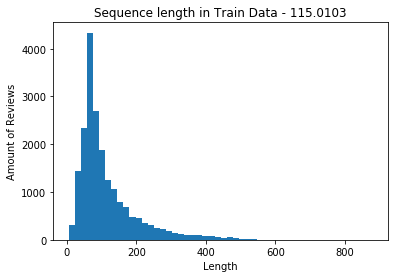

In [36]:
seq_lengths = [len(seq) for seq in train_sequences]
plt.hist(seq_lengths, bins=50)
plt.title("Sequence length in Train Data - {}".format(np.mean(seq_lengths)))
plt.xlabel("Length")
plt.ylabel("Amount of Reviews");

### BRNN Model

- Code

In [40]:
def swish(x):
    """Implementation of swish activation function."""
    return (K.sigmoid(x) * x)

def train_rnn_model(train_sequences, train_targets, val_sequences, val_targets, embedding_size, 
                    batch_size, epochs, seq_length, dict_length):
    """Training BRNN classifier. Applies zero-id padding for too short sequences and shortens too 
    long sequences according to 'seq_length' parameter.
    """
    
    X_train_sequences_pad = sequence.pad_sequences(train_sequences, maxlen=seq_length)
    X_val_sequences_pad = sequence.pad_sequences(val_sequences, maxlen=seq_length)
        
    model = Sequential()
    model.add(Embedding(dict_length, embedding_size, input_length=seq_length))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20, activation="swish"))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
                    
    model.fit(X_train_sequences_pad, train_targets, 
              validation_data=(X_val_sequences_pad, val_targets), 
              batch_size=batch_size, epochs=epochs)
    
    return model

- Training

In [41]:
get_custom_objects().update({"swish": Activation(swish)})

model = train_rnn_model(
    train_sequences, train_targets_seq,
    val_sequences, val_targets_seq,
    embedding_size=128,
    batch_size=100,
    epochs=3,
    seq_length=130,
    dict_length=vocabulary_num
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 20s 975us/sample - loss: 0.4477 - accuracy: 0.7933 - val_loss: 0.3173 - val_accuracy: 0.8662
Epoch 2/3
20000/20000 [==============================] - 18s 887us/sample - loss: 0.2283 - accuracy: 0.9112 - val_loss: 0.3121 - val_accuracy: 0.8672
Epoch 3/3
20000/20000 [==============================] - 18s 897us/sample - loss: 0.1471 - accuracy: 0.9477 - val_loss: 0.3570 - val_accuracy: 0.8644


- Performance

In [42]:
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=130)

scores = model.evaluate(X_test_seq, test_targets_seq, verbose=0)
print("Test accuracy:", scores[1])

Test accuracy: 0.8514


### Summary

In the following notebook, simple method for performing sentiment prediction for documents has been presented.

Three models has been produced that gave similar results on the test dataset:
- Multinominal Naive Bayes - **86.56%** correct predictions
- XGBoost Clasifier - 86.54% correct predictions
- BRNN - 85.14% correct predictions

In such case, the best model would be `Multinominal Naive Bayes` as it is very simple model that doesn't require tuning. It has outperformed `XGBoost` and `BRNN` models that are more complicated and require larger training time.

Good idea would be to perform analysis how each of those models is making mistakes and how does it react to data that it haven't seen.

Apart from that, good thing would be to look at what percentage of tokens inside test and val datasets were not supported. It might give additional information whether current combination of parameters works well or not.

Results depends on data representation - so how the data is preprocessed, cleaned, but also if each token is treated separately or maybe if it's represented in a context. There are many different NLP architectures that could improve the results. For example accordint to [this leaderboard](https://paperswithcode.com/sota/sentiment-analysis-on-imdb), some solutions are capable of achieving 97.7% accuracy.

---
There is additional intake from this notebook. The way corpus is processed with usage of multiprocessing module, allows to speed up building of Bag of Words and TF-IDF variants. Because whole corpus is tokenized and saved in form of list containing list of tokens, it can be didived into chunks that are processed separately and this gives speed up from ~25minutes (on current machine) to ~3 minutes. After that those lists can be passed to `CountVectorizer` that doesn't have to tokenize the data from scratch and can reuse the tokens with any type of filtering, experiment author wants. Creation of such `CountVectorizer` takes seconds. In case of current notebook ~1h was saved thanks to this operation.